In [1]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# load json file for training data
with open('/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train/_annotations.coco.json','r') as file:
    train = json.load(file)
# load json file for validation data
with open('/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/_annotations.coco.json','r') as file:
    valid = json.load(file)
# load json file for test data
with open('/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/test/_annotations.coco.json','r') as file:
    test = json.load(file)

## **Visualization**
<p> Visualizing the images with bounding boxes in addition to thier corresponding segmentation masks<p>

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

train_dir = "/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train"

def plot_image_mask(img_name, segmentation, bbox):
    fig, ax = plt.subplots(1, 2)
    img_path = os.path.join(train_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    scale_x = 256 / 640
    scale_y = 256 / 640
    # Scale bounding box
    scaled_bbox = [int(bbox[0] * scale_x), int(bbox[1] * scale_y), int(bbox[2] * scale_x), int(bbox[3] * scale_y)]
    
    # Draw bounding box
    img_copy = img.copy()
    cv2.rectangle(img_copy, (scaled_bbox[0], scaled_bbox[1]), (scaled_bbox[0] + scaled_bbox[2], scaled_bbox[1] + scaled_bbox[3]), thickness=2, color=(0, 255, 0))
    
    # Scale and draw segmentation mask
    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    polygon = np.array(segmentation[0]).reshape((-1, 2))
    scaled_polygon = polygon * [scale_x, scale_y]
    cv2.fillPoly(mask, [scaled_polygon.astype(int)], 255)
    
    ax[0].imshow(img_copy)
    ax[1].imshow(mask, cmap='gray')
    plt.show()


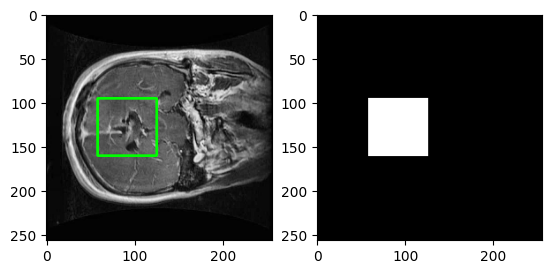

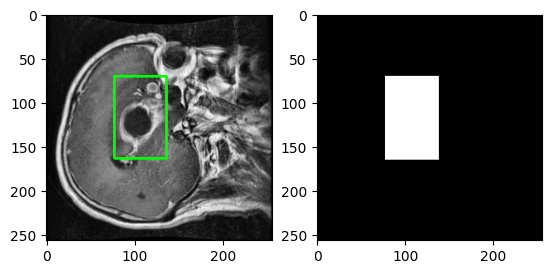

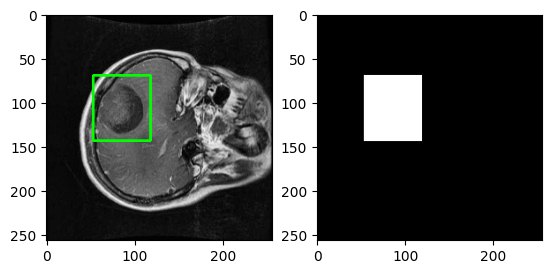

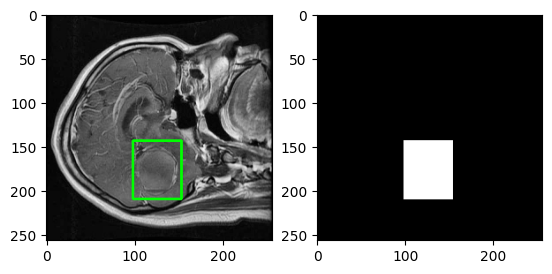

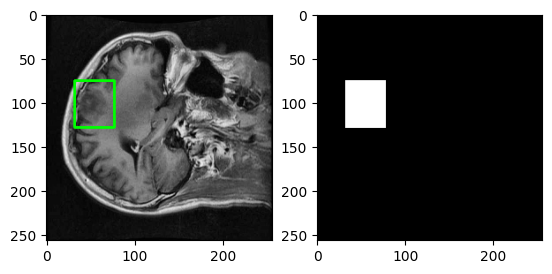

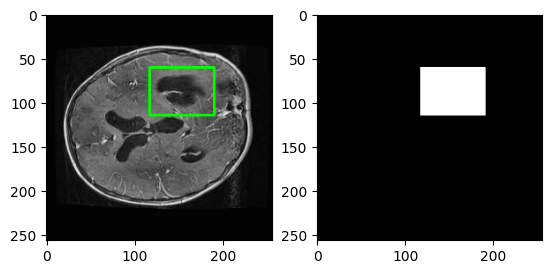

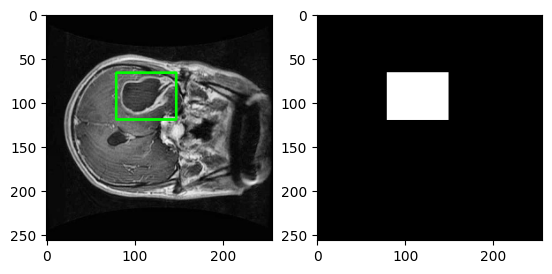

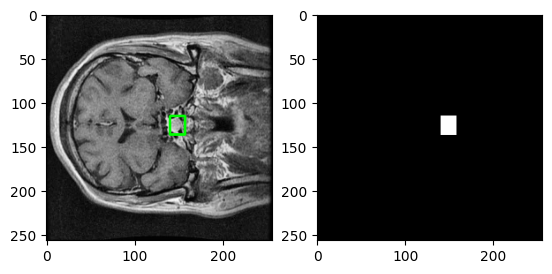

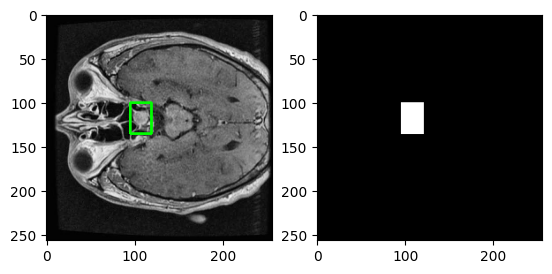

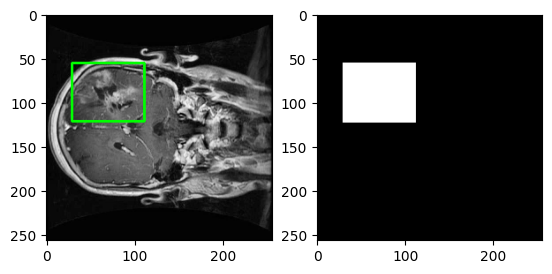

In [4]:
#visualizing the first 10 images
for i in range(10):
    img_name,seg = train['images'][i]['file_name'],[train['annotations'][i]['segmentation']]
    bbox = train['annotations'][i]['bbox']
    plot_image_mask(img_name,seg,bbox)

# **Dataset Creation**

In [5]:
import torch
from torch.utils.data import Dataset,DataLoader

In [6]:
class TumorDataset(Dataset):
    def __init__(self,img_dir,data):
        self.img_dir = img_dir
        self.img_name_ls = [img['file_name'] for img in data['images']]
        self.img_seg_ls = [ann['segmentation'][0] for ann in data['annotations']]
    
    def __len__(self):
        return len(self.img_name_ls)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_name_ls[idx])
        img = cv2.imread(img_path)
        img = cv2.resize(img, (256, 256))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        scale_x = 256 / 640
        scale_y = 256 / 640
    
        mask = np.zeros((256,256),np.uint8)
        poly = np.array(self.img_seg_ls[idx]).reshape(-1,2)
        scaled_poly = poly * [scale_x, scale_y]
        cv2.fillPoly(mask,[scaled_poly.astype(int)],255)
        
        img = torch.tensor(img.transpose(2, 0, 1) / 255.0, dtype=torch.float32)
        mask = torch.tensor(mask / 255.0, dtype=torch.float32)
        
        return img,mask

In [7]:
train_data = TumorDataset(img_dir='/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train',
                         data = train)
val_data = TumorDataset(img_dir='/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid',
                         data = valid)
test_data = TumorDataset(img_dir='/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/test',
                         data = test)

In [8]:
train_loader = DataLoader(
                train_data,
                batch_size = 16,
                shuffle = True,
                num_workers=4)
val_loader = DataLoader(
                val_data,
                batch_size = 1,
                shuffle = False,)
test_loader = DataLoader(
                test_data,
                batch_size = 1,
                shuffle = False)

# **Creating Custom Model(UNET) Architecture**

In [9]:
import torch.nn as nn

In [10]:
def downsample(in_, out_, drop=True):
    layers = [
        nn.Conv2d(in_, out_, kernel_size=(3, 3), padding='same', stride=1),
        nn.BatchNorm2d(out_),
        nn.ReLU(0.2)
    ]
    if drop:
        layers.append(nn.Dropout(0.1))
    return nn.Sequential(*layers)

In [11]:
def upsample(in_,out_,transpose=False):
    if transpose!=True:
        return nn.Sequential(
        nn.Conv2d(in_,out_,kernel_size=3,padding='same',stride=1),
        nn.ReLU(),    
        nn.Conv2d(out_,out_,kernel_size=3,padding='same',stride=1),
        nn.ReLU())
    
    return nn.Sequential(
        nn.ConvTranspose2d(in_,out_,kernel_size=2,stride=2),
        nn.ReLU()
    )

In [12]:
class UNET(nn.Module):
    def __init__(self,in_=3,out_=32):
        super(UNET, self).__init__()
        self.d1 = downsample(in_,out_) #256x256,32
        self.d2 = downsample(out_,out_) # 256x256x32
        self.mp1 = nn.MaxPool2d((2,2),stride=2) #(256-2/2)+1 = 128x128x32
        
        self.d3 = downsample(out_,out_*2) #128x128x64
        self.d4 = downsample(out_*2,out_*2) #128x128x64
        self.mp2 = nn.MaxPool2d((2,2),stride=2) # (128-2/2)+1=64x64x64
        
        self.d5 = downsample(out_*2,out_*2*2) #64x64x128
        self.d6 = downsample(out_*2*2,out_*2*2) #64x64x128
        self.mp3 = nn.MaxPool2d((2,2),stride=2) #(128-2/2)+1=32x32x128
        
        self.d7 = downsample(out_*2*2,out_*2*2*2) #32x32x256
        self.d8 = downsample(out_*2*2*2,out_*2*2*2,drop=True) #32x32x256
        self.mp4 = nn.MaxPool2d((2,2),stride=2) #(32-2/2)+1=16x16x256
        
        self.d9 = downsample(out_*2*2*2,out_*2*2*2*2,drop=True) #16x16x512
        self.mp5 = nn.MaxPool2d((2,2),stride=2) #(16-2/2)+1=8x8x512
        
        self.bn = nn.Conv2d(out_*2*2*2*2,out_*2*2*2*2,(3,3),padding='same',stride=1) #8x8x512
        
        self.up0 = nn.Conv2d(out_*2*2*2*2,out_*2*2*2*2,(3,3),padding='same',stride=1) #8x8x512
        
        self.up1_1 = upsample(out_*2*2*2*2,out_*2*2*2*2,transpose=True) #16x16x512
        self.up1_2 = upsample(out_*2*2*2*2*2,out_*2*2*2*2) #16x16x512
        
        self.up2_1 = upsample(out_*2*2*2*2,out_*2*2*2,transpose=True) #32x32x256
        self.up2_2 = upsample(out_*2*2*2*2,out_*2*2*2) #32x32x256
        
        self.up3_1 = upsample(out_*2*2*2,out_*2*2,transpose=True) #64x64x128
        self.up3_2 = upsample(out_*2*2*2,out_*2*2) #64x64x128
        
        self.up4_1 = upsample(out_*2*2,out_*2,transpose=True) #128x128x64
        self.up4_2 = upsample(out_*2*2,out_*2) #128x128x64
        
        self.up5_1 = upsample(out_*2,out_,transpose=True) #256x256x32
        self.up5_2 = upsample(out_*2,out_) #256x256x32
        
        self.final = nn.Conv2d(out_,1,kernel_size=1,stride=1,padding='same')
        
    def forward(self,x):
        d1 = self.d1(x)
        d2 = self.d2(d1)
        mp1 = self.mp1(d2)
        
        d3 = self.d3(mp1)
        d4 = self.d4(d3)
        mp2 = self.mp2(d4)
        
        d5 = self.d5(mp2)
        d6 = self.d6(d5)
        mp3 = self.mp3(d6)
        
        d7 = self.d7(mp3)
        d8 = self.d8(d7)
        mp4 = self.mp4(d8)
        
        d9 = self.d9(mp4)
        mp5 = self.mp5(d9)
        
        bn = self.bn(mp5)
        
        up0 = self.up0(bn)
        
        up1_1 = self.up1_1(up0)
        up1_2 = self.up1_2(torch.cat([up1_1,d9],1))
        
        up2_1 = self.up2_1(up1_2)
        up2_2 = self.up2_2(torch.cat([up2_1,d8],1))
        
        up3_1 = self.up3_1(up2_2)
        up3_2 = self.up3_2(torch.cat([up3_1,d6],1))
        
        up4_1 = self.up4_1(up3_2)
        up4_2 = self.up4_2(torch.cat([up4_1,d4],1))
        
        up5_1 = self.up5_1(up4_2)
        up5_2 = self.up5_2(torch.cat([up5_1,d2],1))
        
        final = self.final(up5_2)
        
        return nn.Sigmoid()(final)

In [13]:
# testing the model architecture
test = torch.randn(size=(1,3,256,256))
unet = UNET()
out = unet(test)
out.size()

torch.Size([1, 1, 256, 256])

# Training 

In [14]:
from tqdm import tqdm

In [17]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 10

In [16]:
unet = UNET().to(DEVICE)
optimizer = torch.optim.Adam(unet.parameters())
criterion = nn.BCELoss()

In [39]:
for epoch in range(EPOCHS):  
    running_loss = 0.0
    unet.train()  
    for mri, mask in tqdm(train_loader):
        mri, mask = mri.to(DEVICE), mask.to(DEVICE)
        
        optimizer.zero_grad()
        pred = unet(mri)
        loss = criterion(pred, mask.unsqueeze(1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/len(train_loader):.4f}")

100%|██████████| 94/94 [00:16<00:00,  5.58it/s]


Epoch [1/10], Loss: 0.0929


100%|██████████| 94/94 [00:16<00:00,  5.58it/s]


Epoch [2/10], Loss: 0.0903


100%|██████████| 94/94 [00:16<00:00,  5.59it/s]


Epoch [3/10], Loss: 0.0883


100%|██████████| 94/94 [00:16<00:00,  5.57it/s]


Epoch [4/10], Loss: 0.0856


100%|██████████| 94/94 [00:16<00:00,  5.59it/s]


Epoch [5/10], Loss: 0.0851


100%|██████████| 94/94 [00:16<00:00,  5.58it/s]


Epoch [6/10], Loss: 0.0843


100%|██████████| 94/94 [00:16<00:00,  5.59it/s]


Epoch [7/10], Loss: 0.0820


100%|██████████| 94/94 [00:16<00:00,  5.58it/s]


Epoch [8/10], Loss: 0.0846


100%|██████████| 94/94 [00:16<00:00,  5.58it/s]


Epoch [9/10], Loss: 0.0824


100%|██████████| 94/94 [00:16<00:00,  5.58it/s]

Epoch [10/10], Loss: 0.0811


# **Evaluation**

In [40]:
unet.eval()
with torch.no_grad():
    val_loss = 0.0
    for val_mri, val_mask in val_loader:
        val_mri, val_mask = val_mri.to(DEVICE), val_mask.to(DEVICE)
        val_pred = unet(val_mri)
        val_loss += criterion(val_pred, val_mask.unsqueeze(1)).item()
print(f"Validation Loss: {val_loss/len(val_loader):.4f}")

Validation Loss: 0.0791


In [41]:
unet.eval()
with torch.no_grad():
    val_loss = 0.0
    for val_mri, val_mask in test_loader:
        val_mri, val_mask = val_mri.to(DEVICE), val_mask.to(DEVICE)
        val_pred = unet(val_mri)
        val_loss += criterion(val_pred, val_mask.unsqueeze(1)).item()
print(f"Test Loss: {val_loss/len(test_loader):.4f}")

Test Loss: 0.0798


# **Plotting Results**

In [43]:
import random

In [51]:
unet.eval()
to_plot_pred= []
to_plot_mask= []
to_plot_img = []
with torch.no_grad():
    for img,mask in test_loader:
        if len(to_plot_pred)==10:
            break
        if random.choice(np.arange(0,3)) == 2:
            to_plot_pred.append(unet(img.to(DEVICE)).detach().to('cpu').numpy())
            to_plot_mask.append(mask.detach().numpy())
            to_plot_img.append(img.detach().numpy())

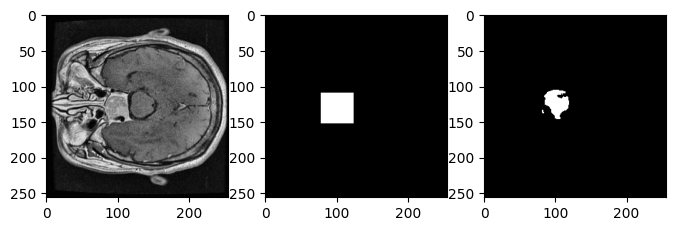

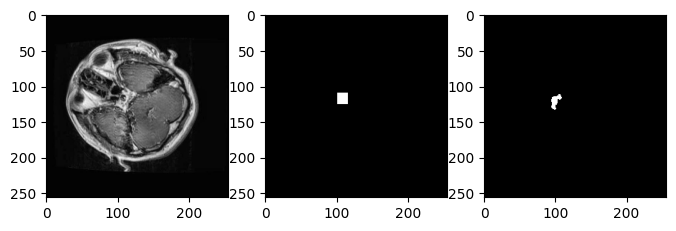

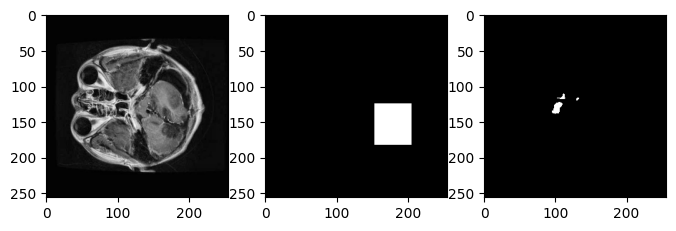

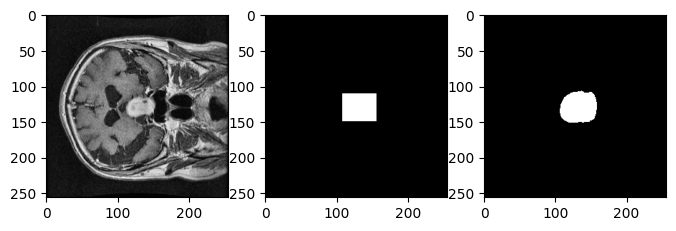

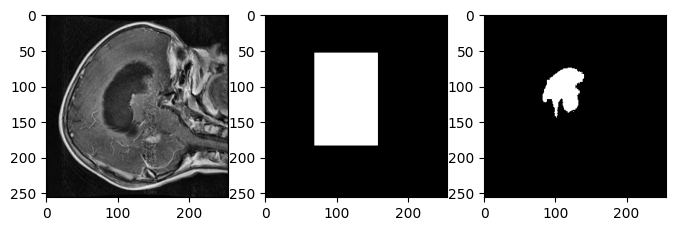

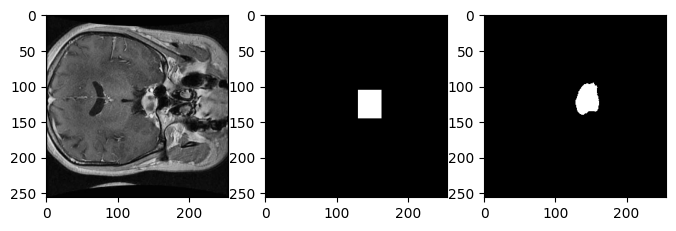

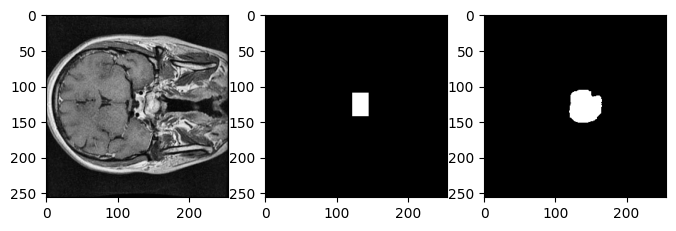

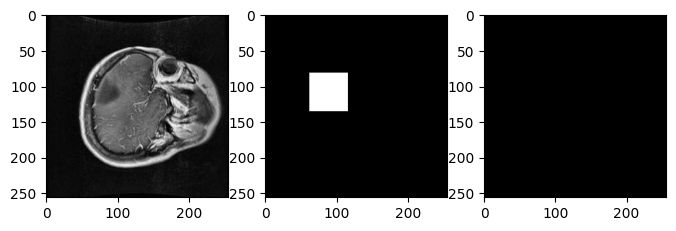

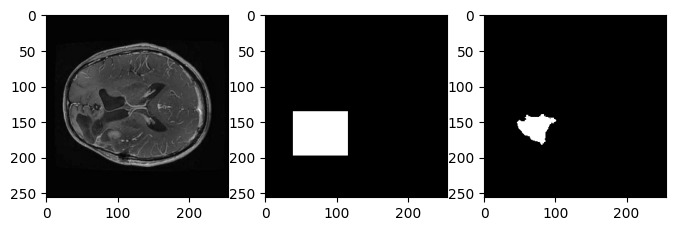

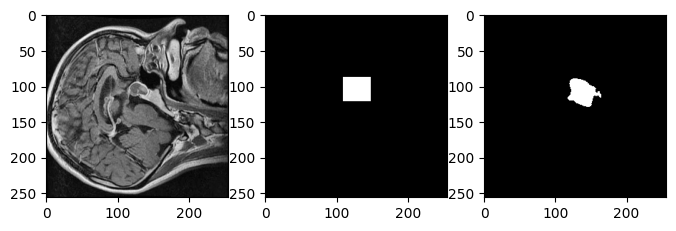

In [52]:
for pred,mask,img in zip(to_plot_pred,to_plot_mask,to_plot_img):
    fig,ax = plt.subplots(1,3,figsize=(8,8))
    ax[0].imshow(img.reshape(3,256,256).transpose(1, 2, 0))
    ax[1].imshow(mask.reshape(256,256),cmap='gray')
    pred = pred.reshape(256,256)
    pred = np.where(1,pred>=0.5,0)
    ax[2].imshow(pred,cmap='gray')
    plt.show()

In [42]:
torch.save(unet.state_dict(), 'unet_model.pth')
